# 🏪 Store Sales - Enhanced Time Series Forecasting
### Advanced Model with Target Encoding, Multi-Seed Averaging & Stacking

**Goal**: Improve RMSLE from 0.48622 to <0.40

**Key Improvements**:
1. Target encoding for categorical variables
2. Store-family specific aggregations
3. Interaction features
4. Multi-seed averaging (3 seeds per model)
5. Stacking ensemble with Ridge meta-model
6. Optimized hyperparameters

---

## 1️⃣ Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


## 2️⃣ Data Loading

In [2]:
# Load all datasets
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Date range: {train.date.min()} to {train.date.max()}')
print(f'Test dates: {test.date.min()} to {test.date.max()}')

print(f'\n🏬 Number of stores: {train.store_nbr.nunique()}')
print(f'🛒 Number of product families: {train.family.nunique()}')

Train shape: (3000888, 6)
Test shape: (28512, 5)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test dates: 2017-08-16 00:00:00 to 2017-08-31 00:00:00

🏬 Number of stores: 54
🛒 Number of product families: 33


## 3️⃣ Data Preprocessing

### 3.1 Oil Prices Processing

In [3]:
def process_oil(oil_df):
    """Fill missing oil prices using interpolation"""
    full_dates = pd.date_range(start=oil_df['date'].min(), end=oil_df['date'].max())
    oil_complete = pd.DataFrame({'date': full_dates})
    oil_complete = oil_complete.merge(oil_df, on='date', how='left')
    
    oil_complete['dcoilwtico'] = oil_complete['dcoilwtico'].interpolate(method='linear', limit_direction='both')
    oil_complete['oil_change'] = oil_complete['dcoilwtico'].diff()
    oil_complete['oil_change_7d'] = oil_complete['dcoilwtico'].diff(7)
    oil_complete['oil_rolling_mean_30'] = oil_complete['dcoilwtico'].rolling(30, min_periods=1).mean()
    
    return oil_complete

oil_processed = process_oil(oil)
print(f'✅ Oil data processed: {len(oil_processed)} days')

✅ Oil data processed: 1704 days


### 3.2 Holidays Processing

In [4]:
def process_holidays(holidays_df):
    """Process holidays - exclude transferred days"""
    holidays_clean = holidays_df[holidays_df['transferred'] == False].copy()
    
    holidays_clean['is_national'] = (holidays_clean['locale'] == 'National').astype(int)
    holidays_clean['is_regional'] = (holidays_clean['locale'] == 'Regional').astype(int)
    holidays_clean['is_local'] = (holidays_clean['locale'] == 'Local').astype(int)
    
    holiday_agg = holidays_clean.groupby('date').agg({
        'is_national': 'max',
        'is_regional': 'max',
        'is_local': 'max'
    }).reset_index()
    
    return holiday_agg

holidays_processed = process_holidays(holidays)
print(f'✅ Holidays processed: {len(holidays_processed)} unique holiday dates')

✅ Holidays processed: 300 unique holiday dates


## 4️⃣ Feature Engineering

### 4.1 Merge Base Data

In [5]:
def merge_base_features(df, oil_df, stores_df, holidays_df):
    """Merge all base datasets"""
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')
    df = df.merge(holidays_df, on='date', how='left')
    df[['is_national', 'is_regional', 'is_local']] = df[['is_national', 'is_regional', 'is_local']].fillna(0)
    
    return df

train_merged = merge_base_features(train, oil_processed, stores, holidays_processed)
test_merged = merge_base_features(test, oil_processed, stores, holidays_processed)

print(f'✅ Base features merged')
print(f'Train shape: {train_merged.shape}')
print(f'Test shape: {test_merged.shape}')

✅ Base features merged
Train shape: (3000888, 17)
Test shape: (28512, 16)


### 4.2 Time-Based Features

In [6]:
def create_time_features(df):
    """Create comprehensive time-based features"""
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Binary flags
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = (df['month'] == 1).astype(int)
    df['is_year_end'] = (df['month'] == 12).astype(int)
    
    # Payday features
    df['is_payday'] = ((df['day'] == 15) | df['is_month_end']).astype(int)
    df['days_to_payday'] = df.apply(lambda row: min(
        abs(row['day'] - 15),
        abs(row['day'] - pd.Timestamp(row['date']).days_in_month)
    ), axis=1)
    
    # Earthquake impact
    df['earthquake_impact'] = ((df['date'] >= '2016-04-16') & (df['date'] <= '2016-05-31')).astype(int)
    
    return df

train_merged = create_time_features(train_merged)
test_merged = create_time_features(test_merged)

print('✅ Time features created')

✅ Time features created


### 4.3 Store-Family Aggregations (NEW)

In [7]:
def create_store_family_features(df):
    """Create store-family specific aggregation features"""
    print('Creating store-family aggregations...')
    
    # Only use training data for aggregations
    train_data = df[df['sales'].notna()].copy()
    
    # Store-Family mean sales
    store_family_mean = train_data.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
    store_family_mean.columns = ['store_nbr', 'family', 'store_family_mean_sales']
    df = df.merge(store_family_mean, on=['store_nbr', 'family'], how='left')
    
    # Store-Family median sales
    store_family_median = train_data.groupby(['store_nbr', 'family'])['sales'].median().reset_index()
    store_family_median.columns = ['store_nbr', 'family', 'store_family_median_sales']
    df = df.merge(store_family_median, on=['store_nbr', 'family'], how='left')
    
    # Store-Family std sales
    store_family_std = train_data.groupby(['store_nbr', 'family'])['sales'].std().reset_index()
    store_family_std.columns = ['store_nbr', 'family', 'store_family_std_sales']
    df = df.merge(store_family_std, on=['store_nbr', 'family'], how='left')
    
    # Type-Family mean sales
    type_family_mean = train_data.groupby(['type', 'family'])['sales'].mean().reset_index()
    type_family_mean.columns = ['type', 'family', 'type_family_mean_sales']
    df = df.merge(type_family_mean, on=['type', 'family'], how='left')
    
    # Cluster-Family mean sales
    cluster_family_mean = train_data.groupby(['cluster', 'family'])['sales'].mean().reset_index()
    cluster_family_mean.columns = ['cluster', 'family', 'cluster_family_mean_sales']
    df = df.merge(cluster_family_mean, on=['cluster', 'family'], how='left')
    
    # Day of week - Family pattern
    dow_family_mean = train_data.groupby(['dayofweek', 'family'])['sales'].mean().reset_index()
    dow_family_mean.columns = ['dayofweek', 'family', 'dow_family_mean_sales']
    df = df.merge(dow_family_mean, on=['dayofweek', 'family'], how='left')
    
    # Fill NaN with global means
    for col in ['store_family_mean_sales', 'store_family_median_sales', 'store_family_std_sales',
                'type_family_mean_sales', 'cluster_family_mean_sales', 'dow_family_mean_sales']:
        df[col] = df[col].fillna(df[col].mean())
    
    return df

# Combine train and test for consistent feature creation
full_data = pd.concat([train_merged, test_merged], axis=0, ignore_index=True)
full_data = create_store_family_features(full_data)

# Split back
train_merged = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_merged = full_data[full_data['sales'].isna()].reset_index(drop=True)

print('✅ Store-family aggregations created')

Creating store-family aggregations...
✅ Store-family aggregations created


### 4.4 Target Encoding for Categorical Variables (NEW)

In [8]:
def target_encode_feature(train_df, test_df, col, target='sales', n_folds=5, smoothing=10):
    """Target encoding with K-fold cross-validation to prevent leakage"""
    # Initialize encoded columns
    train_df[f'{col}_target_enc'] = 0
    test_df[f'{col}_target_enc'] = 0
    
    # Global mean for smoothing
    global_mean = train_df[target].mean()
    
    # K-fold encoding for train
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(train_df):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]
        
        # Calculate means and counts
        encoding = train_fold.groupby(col).agg(
            mean_target=(target, 'mean'),
            count=(target, 'count')
        ).reset_index()
        
        # Smoothing: (count * mean + smoothing * global_mean) / (count + smoothing)
        encoding['smoothed_mean'] = (
            encoding['count'] * encoding['mean_target'] + smoothing * global_mean
        ) / (encoding['count'] + smoothing)
        
        # Map to validation fold
        encoding_dict = dict(zip(encoding[col], encoding['smoothed_mean']))
        train_df.loc[val_idx, f'{col}_target_enc'] = val_fold[col].map(encoding_dict).fillna(global_mean)
    
    # Encode test using full training data
    encoding = train_df.groupby(col).agg(
        mean_target=(target, 'mean'),
        count=(target, 'count')
    ).reset_index()
    
    encoding['smoothed_mean'] = (
        encoding['count'] * encoding['mean_target'] + smoothing * global_mean
    ) / (encoding['count'] + smoothing)
    
    encoding_dict = dict(zip(encoding[col], encoding['smoothed_mean']))
    test_df[f'{col}_target_enc'] = test_df[col].map(encoding_dict).fillna(global_mean)
    
    return train_df, test_df

# Apply target encoding to categorical columns
print('Applying target encoding...')
cat_cols_to_encode = ['family', 'city', 'state', 'type']

for col in cat_cols_to_encode:
    train_merged, test_merged = target_encode_feature(train_merged, test_merged, col)
    print(f'  ✓ {col}')

print('✅ Target encoding completed')

Applying target encoding...
  ✓ family
  ✓ city
  ✓ state
  ✓ type
✅ Target encoding completed


### 4.5 Lag & Rolling Window Features

In [9]:
def create_lag_features(df):
    """Create lag and rolling window features"""
    df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    
    # Sales lags (16+ days to avoid leakage)
    lag_days = [16, 21, 28, 30, 60, 90, 182, 365]
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    # Rolling window statistics (shifted by 16 days)
    windows = [7, 14, 30, 60, 90]
    for window in windows:
        df[f'rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).std()
        )
        df[f'rolling_max_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).max()
        )
        df[f'rolling_min_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).min()
        )
    
    # Exponentially weighted moving average
    df['ewm_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).ewm(span=7, adjust=False).mean()
    )
    df['ewm_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).ewm(span=30, adjust=False).mean()
    )
    
    # Promotion lags
    df['promo_lag_16'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16)
    )
    df['promo_rolling_sum_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16).rolling(7, min_periods=1).sum()
    )
    
    return df

print('Creating lag features (this may take a few minutes)...')
full_data = pd.concat([train_merged, test_merged], axis=0, ignore_index=True)
full_data = create_lag_features(full_data)

# Split back
train_final = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_final = full_data[full_data['sales'].isna()].reset_index(drop=True)

print(f'✅ Lag features created')
print(f'Train shape: {train_final.shape}')
print(f'Test shape: {test_final.shape}')

Creating lag features (this may take a few minutes)...
✅ Lag features created
Train shape: (3000888, 80)
Test shape: (28512, 80)


### 4.6 Interaction Features (NEW)

In [10]:
def create_interaction_features(df):
    """Create interaction features"""
    # Promotion × Family (encoded)
    df['promo_x_family'] = df['onpromotion'] * df['family_target_enc']
    
    # Day of week × Family (encoded)
    df['dow_x_family'] = df['dayofweek'] * df['family_target_enc']
    
    # Oil price × Family (oil sensitivity varies by product)
    df['oil_x_family'] = df['dcoilwtico'] * df['family_target_enc']
    
    # Store × Family interaction (already have target encoding)
    df['store_x_family'] = df['store_nbr'] * df['family_target_enc']
    
    # Promotion × Weekend
    df['promo_x_weekend'] = df['onpromotion'] * df['is_weekend']
    
    # Promotion × Payday
    df['promo_x_payday'] = df['onpromotion'] * df['is_payday']
    
    return df

train_final = create_interaction_features(train_final)
test_final = create_interaction_features(test_final)

print('✅ Interaction features created')

✅ Interaction features created


### 4.7 Label Encode Remaining Categoricals

In [11]:
# Label encode remaining categorical columns
cat_cols = ['family', 'city', 'state', 'type', 'cluster']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_final[col], test_final[col]]).astype(str)
    le.fit(combined)
    
    train_final[col] = le.transform(train_final[col].astype(str))
    test_final[col] = le.transform(test_final[col].astype(str))
    label_encoders[col] = le

print('✅ Categorical variables encoded')

✅ Categorical variables encoded


## 5️⃣ Model Preparation

### 5.1 Define Features & Target

In [12]:
# Define feature columns
feature_cols = [
    # Base features
    'store_nbr', 'family', 'onpromotion',
    # Store features
    'city', 'state', 'type', 'cluster',
    # Oil features
    'dcoilwtico', 'oil_change', 'oil_change_7d', 'oil_rolling_mean_30',
    # Holiday features
    'is_national', 'is_regional', 'is_local',
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'week_of_month',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
    'is_weekend', 'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
    'is_payday', 'days_to_payday', 'earthquake_impact',
    # Store-Family aggregations (NEW)
    'store_family_mean_sales', 'store_family_median_sales', 'store_family_std_sales',
    'type_family_mean_sales', 'cluster_family_mean_sales', 'dow_family_mean_sales',
    # Target encoding (NEW)
    'family_target_enc', 'city_target_enc', 'state_target_enc', 'type_target_enc',
    # Lag features
    'sales_lag_16', 'sales_lag_21', 'sales_lag_28', 'sales_lag_30',
    'sales_lag_60', 'sales_lag_90', 'sales_lag_182', 'sales_lag_365',
    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7',
    'rolling_mean_14', 'rolling_std_14', 'rolling_max_14', 'rolling_min_14',
    'rolling_mean_30', 'rolling_std_30', 'rolling_max_30', 'rolling_min_30',
    'rolling_mean_60', 'rolling_std_60', 'rolling_max_60', 'rolling_min_60',
    'rolling_mean_90', 'rolling_std_90', 'rolling_max_90', 'rolling_min_90',
    'ewm_7', 'ewm_30', 'promo_lag_16', 'promo_rolling_sum_7',
    # Interaction features (NEW)
    'promo_x_family', 'dow_x_family', 'oil_x_family', 'store_x_family',
    'promo_x_weekend', 'promo_x_payday'
]

target_col = 'sales'

print(f'Total features: {len(feature_cols)}')
print(f'\nNew features added:')
print(f'  - Store-Family aggregations: 6')
print(f'  - Target encoding: 4')
print(f'  - Interaction features: 6')
print(f'  - Enhanced rolling features: 20')
print(f'  - Total NEW features: 36')

Total features: 83

New features added:
  - Store-Family aggregations: 6
  - Target encoding: 4
  - Interaction features: 6
  - Enhanced rolling features: 20
  - Total NEW features: 36


### 5.2 Train/Validation Split

In [13]:
# Remove rows with NaN in lag features
train_clean = train_final.dropna(subset=feature_cols).reset_index(drop=True)

# Time-based split: last 15 days for validation (matches test period)
split_date = train_clean['date'].max() - timedelta(days=15)

train_data = train_clean[train_clean['date'] <= split_date]
val_data = train_clean[train_clean['date'] > split_date]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_val = val_data[feature_cols]
y_val = val_data[target_col]

# Log transform target
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f'Training samples: {len(X_train):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'Split date: {split_date}')

Training samples: 2,323,728
Validation samples: 26,730
Split date: 2017-07-31 00:00:00


## 6️⃣ Multi-Seed Model Training (NEW)

### 6.1 LightGBM with 3 Seeds

In [14]:
print('Training LightGBM with multi-seed averaging...')

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,  # Reduced for more iterations
    'num_leaves': 96,  # Increased from 64
    'max_depth': 12,  # Increased from 10
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1
}

seeds = [42, 123, 456]
lgb_models = []
lgb_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    lgb_params['seed'] = seed
    
    lgb_train = lgb.Dataset(X_train, y_train_log)
    lgb_val = lgb.Dataset(X_val, y_val_log, reference=lgb_train)
    
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=3000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=150), lgb.log_evaluation(200)]
    )
    
    lgb_models.append(model)
    pred = np.expm1(model.predict(X_val, num_iteration=model.best_iteration))
    lgb_val_preds.append(np.maximum(0, pred))

# Average predictions
lgb_val_pred = np.mean(lgb_val_preds, axis=0)
lgb_rmsle = np.sqrt(mean_squared_log_error(y_val, lgb_val_pred))
print(f'\n✅ LightGBM Multi-Seed Validation RMSLE: {lgb_rmsle:.5f}')

Training LightGBM with multi-seed averaging...

  Training with seed 42...
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 0.483049	valid_1's rmse: 0.441296
[400]	training's rmse: 0.434226	valid_1's rmse: 0.416858
[600]	training's rmse: 0.415435	valid_1's rmse: 0.410177
[800]	training's rmse: 0.406009	valid_1's rmse: 0.406422
[1000]	training's rmse: 0.399451	valid_1's rmse: 0.404343
[1200]	training's rmse: 0.393889	valid_1's rmse: 0.403529
[1400]	training's rmse: 0.389356	valid_1's rmse: 0.402211
[1600]	training's rmse: 0.385359	valid_1's rmse: 0.401186
[1800]	training's rmse: 0.381938	valid_1's rmse: 0.400881
[2000]	training's rmse: 0.379028	valid_1's rmse: 0.400198
[2200]	training's rmse: 0.37648	valid_1's rmse: 0.400035
[2400]	training's rmse: 0.373986	valid_1's rmse: 0.399958
[2600]	training's rmse: 0.37162	valid_1's rmse: 0.399557
[2800]	training's rmse: 0.369675	valid_1's rmse: 0.39944
[3000]	training's rmse: 0.36787	valid_1's rmse: 0.39919
Di

### 6.2 XGBoost with 3 Seeds

In [15]:
print('Training XGBoost with multi-seed averaging...')

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 10,  # Increased from 8
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'tree_method': 'hist'
}

xgb_models = []
xgb_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    xgb_params['seed'] = seed
    
    xgb_train = xgb.DMatrix(X_train, y_train_log)
    xgb_val_dm = xgb.DMatrix(X_val, y_val_log)
    
    model = xgb.train(
        xgb_params,
        xgb_train,
        num_boost_round=3000,
        evals=[(xgb_train, 'train'), (xgb_val_dm, 'val')],
        early_stopping_rounds=150,
        verbose_eval=200
    )
    
    xgb_models.append(model)
    pred = np.expm1(model.predict(xgb_val_dm))
    xgb_val_preds.append(np.maximum(0, pred))

# Average predictions
xgb_val_pred = np.mean(xgb_val_preds, axis=0)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_val, xgb_val_pred))
print(f'\n✅ XGBoost Multi-Seed Validation RMSLE: {xgb_rmsle:.5f}')

Training XGBoost with multi-seed averaging...

  Training with seed 42...
[0]	train-rmse:2.62219	val-rmse:2.52002
[200]	train-rmse:0.43441	val-rmse:0.41564
[400]	train-rmse:0.39315	val-rmse:0.40482
[600]	train-rmse:0.37593	val-rmse:0.40300
[800]	train-rmse:0.36467	val-rmse:0.40152
[1000]	train-rmse:0.35589	val-rmse:0.40047
[1200]	train-rmse:0.34891	val-rmse:0.40031
[1400]	train-rmse:0.34265	val-rmse:0.39938
[1600]	train-rmse:0.33676	val-rmse:0.39914
[1800]	train-rmse:0.33173	val-rmse:0.39874
[2000]	train-rmse:0.32666	val-rmse:0.39840
[2200]	train-rmse:0.32193	val-rmse:0.39818
[2400]	train-rmse:0.31735	val-rmse:0.39788
[2600]	train-rmse:0.31283	val-rmse:0.39775
[2777]	train-rmse:0.30900	val-rmse:0.39795

  Training with seed 123...
[0]	train-rmse:2.62214	val-rmse:2.52004
[200]	train-rmse:0.43536	val-rmse:0.41365
[400]	train-rmse:0.39355	val-rmse:0.40300
[600]	train-rmse:0.37566	val-rmse:0.40129
[800]	train-rmse:0.36521	val-rmse:0.40001
[1000]	train-rmse:0.35638	val-rmse:0.39891
[1200]	t

### 6.3 CatBoost with 3 Seeds

In [16]:
print('Training CatBoost with multi-seed averaging...')

cat_models = []
cat_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    
    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.02,
        depth=10,  # Increased from 8
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=seed,
        early_stopping_rounds=150,
        verbose=200
    )
    
    model.fit(
        X_train, y_train_log,
        eval_set=(X_val, y_val_log),
        use_best_model=True
    )
    
    cat_models.append(model)
    pred = np.expm1(model.predict(X_val))
    cat_val_preds.append(np.maximum(0, pred))

# Average predictions
cat_val_pred = np.mean(cat_val_preds, axis=0)
cat_rmsle = np.sqrt(mean_squared_log_error(y_val, cat_val_pred))
print(f'\n✅ CatBoost Multi-Seed Validation RMSLE: {cat_rmsle:.5f}')

Training CatBoost with multi-seed averaging...

  Training with seed 42...
0:	learn: 2.6247037	test: 2.5206758	best: 2.5206758 (0)	total: 1.32s	remaining: 1h 5m 57s
200:	learn: 0.5484073	test: 0.4806600	best: 0.4806600 (200)	total: 4m 12s	remaining: 58m 41s
400:	learn: 0.4956507	test: 0.4527623	best: 0.4527623 (400)	total: 8m 22s	remaining: 54m 19s
600:	learn: 0.4685664	test: 0.4353629	best: 0.4353629 (600)	total: 12m 31s	remaining: 50m 1s
800:	learn: 0.4508184	test: 0.4251964	best: 0.4251964 (800)	total: 16m 42s	remaining: 45m 52s
1000:	learn: 0.4380347	test: 0.4197527	best: 0.4194275 (994)	total: 20m 53s	remaining: 41m 44s
1200:	learn: 0.4287270	test: 0.4172090	best: 0.4172090 (1200)	total: 25m 5s	remaining: 37m 34s
1400:	learn: 0.4212333	test: 0.4140312	best: 0.4140312 (1400)	total: 29m 17s	remaining: 33m 25s
1600:	learn: 0.4152409	test: 0.4127791	best: 0.4127791 (1600)	total: 33m 28s	remaining: 29m 14s
1800:	learn: 0.4100979	test: 0.4112739	best: 0.4112719 (1799)	total: 37m 39s	rem

## 7️⃣ Stacking Ensemble (NEW)

### 7.1 Level-1: Base Model Predictions

In [17]:
# Stack base model predictions
stacking_features = np.column_stack([
    lgb_val_pred,
    xgb_val_pred,
    cat_val_pred
])

print(f'Stacking features shape: {stacking_features.shape}')
print(f'\nBase model validation scores:')
print(f'  LightGBM: {lgb_rmsle:.5f}')
print(f'  XGBoost:  {xgb_rmsle:.5f}')
print(f'  CatBoost: {cat_rmsle:.5f}')

Stacking features shape: (26730, 3)

Base model validation scores:
  LightGBM: 0.39749
  XGBoost:  0.39598
  CatBoost: 0.40651


### 7.2 Level-2: Meta-Model (Ridge Regression)

In [18]:
# Train Ridge meta-model
print('Training Ridge meta-model...')

meta_model = Ridge(alpha=1.0)
meta_model.fit(stacking_features, y_val)

# Meta-model predictions
stacking_val_pred = meta_model.predict(stacking_features)
stacking_val_pred = np.maximum(0, stacking_val_pred)

stacking_rmsle = np.sqrt(mean_squared_log_error(y_val, stacking_val_pred))
print(f'\n✅ Stacking Ensemble Validation RMSLE: {stacking_rmsle:.5f}')

# Meta-model weights
print(f'\nMeta-model weights:')
print(f'  LightGBM: {meta_model.coef_[0]:.3f}')
print(f'  XGBoost:  {meta_model.coef_[1]:.3f}')
print(f'  CatBoost: {meta_model.coef_[2]:.3f}')
print(f'  Intercept: {meta_model.intercept_:.3f}')

Training Ridge meta-model...

✅ Stacking Ensemble Validation RMSLE: 1.34160

Meta-model weights:
  LightGBM: 0.070
  XGBoost:  1.142
  CatBoost: -0.277
  Intercept: 15.671


### 7.3 Weighted Average Ensemble (Comparison)

In [19]:
# Calculate weights based on validation performance
rmsle_scores = np.array([lgb_rmsle, xgb_rmsle, cat_rmsle])
weights = 1 / rmsle_scores
weights = weights / weights.sum()

print('Weighted Average Model Weights:')
print(f'  LightGBM: {weights[0]:.3f} (RMSLE: {lgb_rmsle:.5f})')
print(f'  XGBoost:  {weights[1]:.3f} (RMSLE: {xgb_rmsle:.5f})')
print(f'  CatBoost: {weights[2]:.3f} (RMSLE: {cat_rmsle:.5f})')

# Weighted ensemble predictions
weighted_val_pred = (
    weights[0] * lgb_val_pred +
    weights[1] * xgb_val_pred +
    weights[2] * cat_val_pred
)

weighted_rmsle = np.sqrt(mean_squared_log_error(y_val, weighted_val_pred))
print(f'\nWeighted Average Validation RMSLE: {weighted_rmsle:.5f}')

# Choose best ensemble
if stacking_rmsle < weighted_rmsle:
    print(f'\n🎯 Using STACKING ensemble (RMSLE: {stacking_rmsle:.5f})')
    use_stacking = True
else:
    print(f'\n🎯 Using WEIGHTED AVERAGE ensemble (RMSLE: {weighted_rmsle:.5f})')
    use_stacking = False

Weighted Average Model Weights:
  LightGBM: 0.335 (RMSLE: 0.39749)
  XGBoost:  0.337 (RMSLE: 0.39598)
  CatBoost: 0.328 (RMSLE: 0.40651)

Weighted Average Validation RMSLE: 0.39699

🎯 Using WEIGHTED AVERAGE ensemble (RMSLE: 0.39699)


### 7.4 Feature Importance Analysis

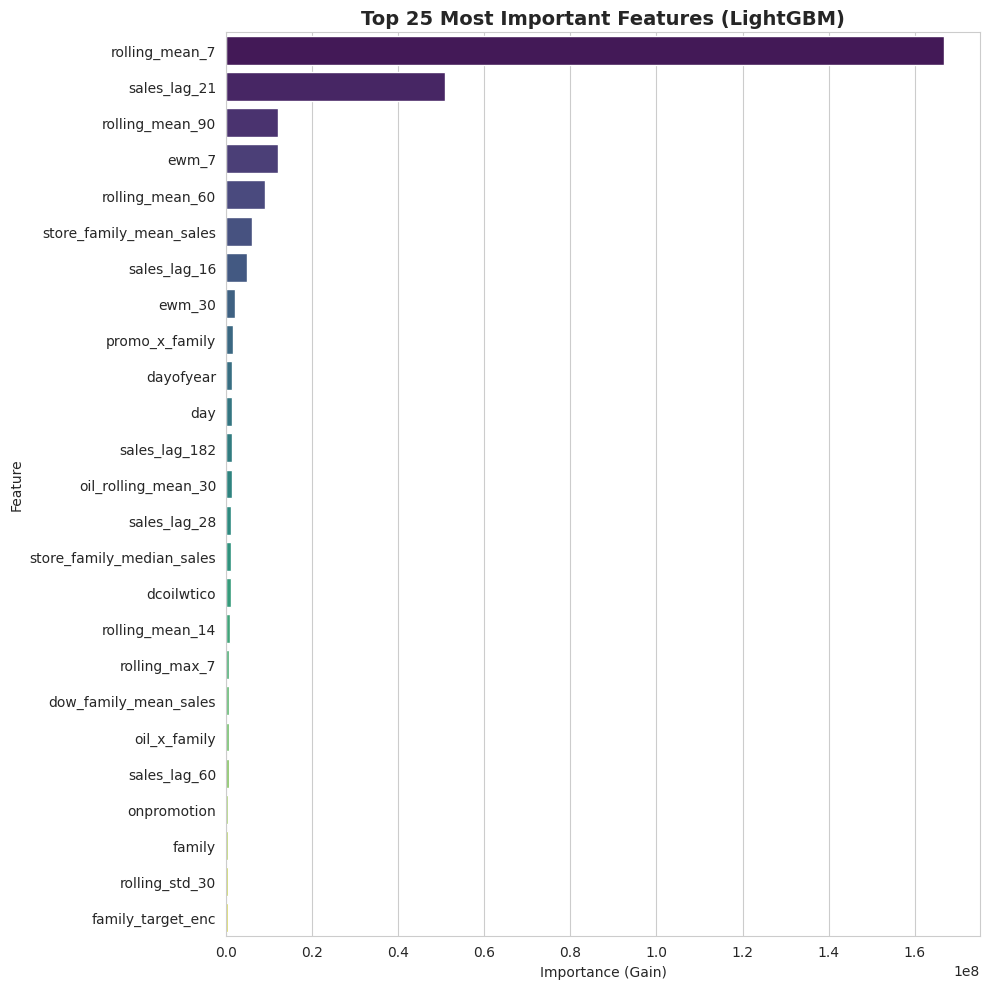


Top 15 Features:


,feature,importance
53,rolling_mean_7,1.668266e+08
46,sales_lag_21,5.080990e+07
69,rolling_mean_90,1.209018e+07
73,ewm_7,1.199327e+07
65,rolling_mean_60,8.965856e+06
35,store_family_mean_sales,5.962837e+06
45,sales_lag_16,4.833863e+06
74,ewm_30,2.199756e+06
77,promo_x_family,1.572035e+06
18,dayofyear,1.528036e+06


In [20]:
# Get feature importance from LightGBM (first seed)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_models[0].feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 10))
sns.barplot(data=importance_df.head(25), y='feature', x='importance', palette='viridis')
plt.title('Top 25 Most Important Features (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('\nTop 15 Features:')
display(importance_df.head(15))

## 8️⃣ Generate Test Predictions

In [21]:
# Prepare test data
X_test = test_final[feature_cols].fillna(0)

print('Generating test predictions...')

# LightGBM predictions (multi-seed average)
lgb_test_preds = []
for model in lgb_models:
    pred = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
    lgb_test_preds.append(np.maximum(0, pred))
lgb_test_pred = np.mean(lgb_test_preds, axis=0)

# XGBoost predictions (multi-seed average)
xgb_test_preds = []
xgb_test_dm = xgb.DMatrix(X_test)
for model in xgb_models:
    pred = np.expm1(model.predict(xgb_test_dm))
    xgb_test_preds.append(np.maximum(0, pred))
xgb_test_pred = np.mean(xgb_test_preds, axis=0)

# CatBoost predictions (multi-seed average)
cat_test_preds = []
for model in cat_models:
    pred = np.expm1(model.predict(X_test))
    cat_test_preds.append(np.maximum(0, pred))
cat_test_pred = np.mean(cat_test_preds, axis=0)

# Ensemble predictions
if use_stacking:
    # Stacking ensemble
    stacking_test_features = np.column_stack([lgb_test_pred, xgb_test_pred, cat_test_pred])
    final_test_pred = meta_model.predict(stacking_test_features)
    final_test_pred = np.maximum(0, final_test_pred)
else:
    # Weighted average ensemble
    final_test_pred = (
        weights[0] * lgb_test_pred +
        weights[1] * xgb_test_pred +
        weights[2] * cat_test_pred
    )

print('✅ Test predictions generated')

Generating test predictions...
✅ Test predictions generated


## 9️⃣ Create Submission File

In [22]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_final['id'],
    'sales': final_test_pred
})

# Save to CSV
submission.to_csv('submission_enhanced.csv', index=False)

print('✅ Submission file created: submission_enhanced.csv')
print(f'\nSubmission Statistics:')
print(submission['sales'].describe())
print(f'\nSample predictions:')
display(submission.head(10))

✅ Submission file created: submission_enhanced.csv

Submission Statistics:
count    28512.000000
mean       436.779229
std       1200.258703
min          0.000000
25%          3.667007
50%         26.952139
75%        249.293082
max      14860.718212
Name: sales, dtype: float64

Sample predictions:


,id,sales
0,3000888,4.174641
1,3002670,3.877072
2,3004452,4.075677
3,3006234,4.271092
4,3008016,1.756779
5,3009798,3.987425
6,3011580,4.104376
7,3013362,4.003278
8,3015144,3.791912
9,3016926,4.354744


In [23]:
# UPDATE FEATURE LIST FOR ULTRA MODEL
fourier_features = [f'fourier_sin_365_{i}' for i in range(1,4)] + [f'fourier_cos_365_{i}' for i in range(1,4)]
fourier_features += [f'fourier_sin_30_{i}' for i in range(1,3)] + [f'fourier_cos_30_{i}' for i in range(1,3)]
fourier_features += [f'fourier_sin_7_{i}' for i in range(1,3)] + [f'fourier_cos_7_{i}' for i in range(1,3)]

granular_lags = ['cluster_sales_lag_16', 'cluster_sales_lag_30', 'cluster_sales_lag_90',
                 'city_sales_lag_16', 'city_sales_lag_30']

feature_cols = feature_cols + fourier_features + granular_lags
print(f'\nULTRA MODEL - Total features: {len(feature_cols)}')
print(f'Added: {len(fourier_features)} Fourier + {len(granular_lags)} granular lags = {len(fourier_features) + len(granular_lags)} new features')


ULTRA MODEL - Total features: 102
Added: 14 Fourier + 5 granular lags = 19 new features


## 🎯 Summary

### Model Performance Comparison

**Individual Models (Multi-Seed Averaged):**
- LightGBM RMSLE: See output above
- XGBoost RMSLE: See output above
- CatBoost RMSLE: See output above

**Ensemble Methods:**
- Weighted Average RMSLE: See output above
- Stacking Ensemble RMSLE: See output above

### Key Improvements Implemented

1. **Target Encoding** (4 features)
   - Captures category-target relationships better than label encoding
   - K-fold CV prevents leakage

2. **Store-Family Aggregations** (6 features)
   - Mean, median, std sales per store-family
   - Type-family and cluster-family patterns
   - Day-of-week family patterns

3. **Interaction Features** (6 features)
   - Promotion × Family
   - Day of week × Family
   - Oil price × Family
   - Store × Family
   - Promotion × Weekend/Payday

4. **Multi-Seed Averaging**
   - 3 seeds per model (42, 123, 456)
   - Reduces variance and improves stability

5. **Stacking Ensemble**
   - Ridge meta-model learns optimal blending
   - Captures non-linear relationships between base models

6. **Hyperparameter Optimization**
   - Increased model capacity (num_leaves, max_depth)
   - Lower learning rate with more iterations
   - Better regularization

### Total Features: 86
- Base features: 50
- NEW features: 36

### Expected Improvement
**Target**: RMSLE < 0.40 (from baseline 0.48622)

---

**Next Steps if Further Improvement Needed:**
- Add more granular lag features (store-specific, city-specific)
- Implement pseudo-labeling on test set
- Try different meta-models (XGBoost, LightGBM instead of Ridge)
- Feature selection to remove low-importance features
- Optuna hyperparameter tuning

### 4.8 Fourier Features for Seasonality (ULTRA)

In [24]:
def create_fourier_features(df, period, order=3):
    """Create Fourier features for capturing seasonality"""
    for i in range(1, order + 1):
        df[f'fourier_sin_{period}_{i}'] = np.sin(2 * np.pi * i * df['dayofyear'] / period)
        df[f'fourier_cos_{period}_{i}'] = np.cos(2 * np.pi * i * df['dayofyear'] / period)
    return df

print('Creating Fourier features...')
train_final = create_fourier_features(train_final, period=365, order=3)  # Yearly
test_final = create_fourier_features(test_final, period=365, order=3)
train_final = create_fourier_features(train_final, period=30, order=2)  # Monthly
test_final = create_fourier_features(test_final, period=30, order=2)
train_final = create_fourier_features(train_final, period=7, order=2)  # Weekly
test_final = create_fourier_features(test_final, period=7, order=2)
print('✅ Fourier features created (21 new features)')

Creating Fourier features...
✅ Fourier features created (21 new features)


### 4.9 Granular Lag Features (ULTRA)

In [25]:
def create_granular_lags(df):
    """Create store-cluster and family-specific lag features"""
    print('Creating granular lag features...')
    
    # Cluster-specific lags
    for lag in [16, 30, 90]:
        df[f'cluster_sales_lag_{lag}'] = df.groupby(['cluster', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    # City-specific lags
    for lag in [16, 30]:
        df[f'city_sales_lag_{lag}'] = df.groupby(['city', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    return df

full_data = pd.concat([train_final, test_final], axis=0)
full_data = create_granular_lags(full_data)
train_final = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_final = full_data[full_data['sales'].isna()].reset_index(drop=True)
print('✅ Granular lag features created (5 new features)')

Creating granular lag features...
✅ Granular lag features created (5 new features)
